# Training machine learning models 

## <a id="toc1_"></a>[Authors](#toc0_)
* **Alireza Arbabi**
* **Hadi Babalou**
* **Ali Padyav**
* **Kasra Hajiheidari**

## <a id='toc2_'></a>[Table of Contents](#toc0_)

**Table of contents**<a id='toc0_'></a>
- [Authors](#toc1_)    
- [Table of Contents](#toc2_)    
- [Setting Up the Environment](#toc3_)    
- [Loading the Data](#toc4_)    
- [Schema of the Data](#toc5_)  
- [Preprocessing the Data](#toc6_) 
- [Feature Engineering and Selection](#toc7_) 
- [Dimensionality Reduction](#toc8_) 
- [Evaluation Metric](#toc9_) 
- [Model Training](#toc10_) 
- [Feature Analysis](#toc11_) 
- [Overall Report and Discussions](#toc12_) 

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL --> 

## <a id='toc3_'></a>[Setting Up the Environment](#toc0_)

In [133]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import keras_tuner as kt
import ast
import numpy as np

## <a id='toc4_'></a>[Loading the Data](#toc0_)
This is the preprocessed dataset from phase 1.

In [134]:
data = pd.read_csv('dataset.csv')
data.head(5)

,track_name,album_name,artists,explicit,key,mode,time_signature,danceability,energy,loudness,...,week_of_year,day,day_of_week,day_of_year,duration_mins,duration_ms,artist_count,genre_count,track_genre,popularity
0,Ode To The Mets,The New Abnormal,['The Strokes'],False,1,0,4.0,0.4280,0.617,-5.424,...,15,10,Friday,101,5.863117,351787,1,2,"['alt-rock', 'garage']",67
1,Glaciers,Bloom,['Lights & Motion'],False,7,1,4.0,0.0789,0.160,-18.144,...,5,2,Friday,33,2.939550,176373,1,1,['ambient'],49
2,Uber Pussy,Pink Season,['Pink Guy'],True,7,1,4.0,0.8700,0.597,-6.320,...,1,4,Wednesday,4,1.956017,117361,1,1,['comedy'],39
3,2002,Speak Your Mind (Deluxe),['Anne-Marie'],False,1,0,4.0,0.6970,0.683,-2.881,...,17,27,Friday,117,3.116450,186987,1,3,"['dance', 'house', 'pop']",82
4,Monsters You Made (feat. Chris Martin),Twice As Tall,"['Burna Boy', 'Chris Martin']",True,7,0,4.0,0.6710,0.646,-7.513,...,33,13,Thursday,226,3.625683,217541,2,1,['dancehall'],45


## <a id='toc5_'></a>[Schema of the Data](#toc0_)

In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4724 entries, 0 to 4723
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        4724 non-null   object 
 1   album_name        4724 non-null   object 
 2   artists           4724 non-null   object 
 3   explicit          4724 non-null   bool   
 4   key               4724 non-null   int64  
 5   mode              4724 non-null   int64  
 6   time_signature    4724 non-null   float64
 7   danceability      4724 non-null   float64
 8   energy            4724 non-null   float64
 9   loudness          4724 non-null   float64
 10  speechiness       4724 non-null   float64
 11  acousticness      4724 non-null   float64
 12  instrumentalness  4724 non-null   float64
 13  liveness          4724 non-null   float64
 14  valence           4724 non-null   float64
 15  tempo             4724 non-null   float64
 16  track_id          4724 non-null   object 


## <a id='toc6_'></a>[Preprocessing the Data](#toc0_)

In the first phase we have done some tasks in order to preprocess our data such as:
  - Handling missing Values 
  - Handling duplicates  
  - Make type Conversions 
  - Removing outliers  
  - Feature Engineering  
  - Reordering the columns  

Now we do complementary preprocessing to make our data ready for modeling. First we remove ID columns because they are not useful for the model.

In [136]:
data = data.drop(['track_id', 'album_id', 'artist_ids'], axis=1)

Also we drop `duration_ms` column since we have the duration in minutes. 

In [137]:
data = data.drop(['duration_ms'], axis=1)

Now we want to convert categorical features to numerical. First of all we find all of the categorical features.

In [138]:
non_numeric_cols = data.select_dtypes(exclude=['int', 'float', 'bool']).columns
for col in non_numeric_cols:
    print(f'{col}: {data[col].dtype}')

track_name: object
album_name: object
artists: object
release_date: object
day_of_week: object
track_genre: object


As we extracted the date information, we can remove the original date columns.

In [139]:
data = data.drop(['release_date'], axis=1)

In [140]:
data['track_genre'] = data['track_genre'].apply(lambda x: ast.literal_eval(x))
# data['artists'] = data['artists'].apply(lambda x: ast.literal_eval(x))

## <a id="toc7_"></a>[Feature Engineering and Selection](#toc0_)

First of all we normalize our numerical features.

In [141]:
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
X = data[numerical_features].drop(columns=['popularity'])
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = data['popularity']
data.drop(columns=numerical_features, inplace=True)

In many machine learning frameworks and libraries, boolean data types are automatically handled as 0 (False) and 1 (True) when used in modeling. This means that in most cases, you do not need to manually convert boolean data types to integers. However, it is good to ensure consistency in your data types, especially when preprocessing your data.

In [142]:
data['explicit'] = data['explicit'].astype(int)

In [143]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4724 entries, 0 to 4723
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   track_name   4724 non-null   object
 1   album_name   4724 non-null   object
 2   artists      4724 non-null   object
 3   explicit     4724 non-null   int32 
 4   day_of_week  4724 non-null   object
 5   track_genre  4724 non-null   object
dtypes: int32(1), object(5)
memory usage: 203.1+ KB


Here we extract all of genres in our dataset to use them as new onehot features.

In [144]:
genres = set()
for genre_list in data['track_genre']:
    for genre in genre_list:
        genres.add(genre)
print(f'Unique genres: {len(genres)}')

Unique genres: 111


In [145]:
genre_counts = {}
for genre_list in data['track_genre']:
    for genre in genre_list:
        if genre in genre_counts:
            genre_counts[genre] += 1
        else:
            genre_counts[genre] = 1
i = 0
for genre, count in genre_counts.items():
    if(count > 5):
        i += 1
print(f'Genres with more than 20 tracks: {i}')

Genres with more than 20 tracks: 104


In [146]:
mlb = MultiLabelBinarizer()

one_hot_genres = mlb.fit_transform(data['track_genre'])
one_hot_df = pd.DataFrame(one_hot_genres, columns=mlb.classes_)
data = pd.concat([data, one_hot_df], axis=1)
data = data.drop(columns=['track_genre'])

In [147]:
data['day_of_week'] = data['day_of_week'].astype(pd.StringDtype())

onehotencoder = OneHotEncoder()
day_of_week_encoded = onehotencoder.fit_transform(data[['day_of_week']]).toarray()
day_of_week_encoded_df = pd.DataFrame(day_of_week_encoded, columns=onehotencoder.get_feature_names_out(['day_of_week']))
data = pd.concat([data, day_of_week_encoded_df], axis=1)
data.drop(columns=['day_of_week'], inplace=True)

Since other categorical columns will not give our model any insights we drop them.

In [148]:
data = data.drop(columns=['track_name', 'album_name', 'artists'])

In the last step we concat our data.

In [149]:
X = pd.concat([X, data], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4724 entries, 0 to 4723
Columns: 143 entries, key to day_of_week_Wednesday
dtypes: float64(31), int32(112)
memory usage: 3.1 MB


## <a id="toc8_"></a>[Dimensionality Reduction](#toc0_)

**Principal Component Analysis (PCA)**

In [150]:
pca = PCA(n_components=0.9, random_state=31)
X_reduced = pca.fit_transform(X)
pca.explained_variance_ratio_
X_reduced_df = pd.DataFrame(X_reduced, columns=[f'PC{i}' for i in range(1, X_reduced.shape[1] + 1)])

# print(selected_columns)
print("Number of columns after PCA reduction:", X_reduced_df.columns.size)
print("Number of columns in the origianl Dataset:", X.columns.size)
print("Reduction Ratio", X_reduced_df.columns.size / X.columns.size)
print("Explained variance after reduction", np.cumsum(pca.explained_variance_ratio_)[-1])

Number of columns after PCA reduction: 19
Number of columns in the origianl Dataset: 143
Reduction Ratio 0.13286713286713286
Explained variance after reduction 0.9107544770813634


In [151]:
print("Correspondnig variances of each feature with the first PCA component:")
selected_columns = X.columns[pca.components_[0].argsort()[::-1]]
for col in selected_columns:
    print(f"    - {col}: {pca.components_[0][X.columns.get_loc(col)]}")

Correspondnig variances of each feature with the first PCA component:
    - acousticness: 0.12653773828983864
    - instrumentalness: 0.06520740346576347
    - mode: 0.05044159861027342
    - track_number: 0.040148947735192286
    - duration_mins: 0.030474896965114285
    - disc_number: 0.02924372096144029
    - new-age: 0.020487352455694323
    - day_of_week_Sunday: 0.014895449097992466
    - day_of_week_Monday: 0.014773916019145478
    - day_of_week_Saturday: 0.014268876249712174
    - day_of_week_Wednesday: 0.009346432598644634
    - valence: 0.008078510326841603
    - day_of_week_Thursday: 0.007854458170976759
    - honky-tonk: 0.006966266144211703
    - liveness: 0.006864307270931351
    - hard-rock: 0.00632187375837767
    - psych-rock: 0.006117611531518381
    - day_of_week_Tuesday: 0.0058255011282199835
    - bluegrass: 0.0057867257581864905
    - power-pop: 0.005585630073472483
    - rockabilly: 0.005178753260742205
    - disco: 0.004476570645734139
    - grindcore: 0.00438252

In [152]:
# categorical_features = data.select_dtypes(exclude=['int', 'float']).columns
# numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# numeric_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())])

# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)])

# X_processed = preprocessor.fit_transform(X)

In [153]:
# print(categorical_features)

### Train and Test Data

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3779, 143), (945, 143), (3779,), (945,))

In [155]:
non_numeric_cols = data.select_dtypes(exclude=['int', 'float', 'bool']).columns
for col in non_numeric_cols:
    print(f'{col}: {data[col].dtype}')

## <a id="toc9_"></a>[Evaluation Metric](#toc0_)

MSE

## <a id="toc10_"></a>[Model Training](#toc0_)

In [156]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

c:\Users\Mr. Hajiheideri\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [157]:
def fit_and_predict(model, X_train, y_train, X_test, y_test, epochs=20, validation_split=0.2, batch_size=10):
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split, batch_size=batch_size)
    y_pred = model.predict(X_test)

    return history, y_pred

In [158]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    history, y_pred = fit_and_predict(model, X_train, y_train, X_test, y_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.title('True vs Predicted Popularity')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Epoch 1/20


303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1154.9495 - mean_absolute_error: 27.1653 - val_loss: 214.3602 - val_mean_absolute_error: 11.8040
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 218.3763 - mean_absolute_error: 11.8740 - val_loss: 170.7062 - val_mean_absolute_error: 10.4302
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 180.8737 - mean_absolute_error: 10.7095 - val_loss: 153.5769 - val_mean_absolute_error: 9.8031
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 174.8362 - mean_absolute_error: 10.3615 - val_loss: 143.3019 - val_mean_absolute_error: 9.3187
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 151.4715 - mean_absolute_error: 9.6822 - val_loss: 137.8961 - val_mean_absolute_error: 9.0966
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 130.3957 - mean_absolute_error: 8.8316 - val_loss: 129.6709 - val_mean_absolute_error: 8.7963
Epoch 7/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 125.6299 - mean_abso

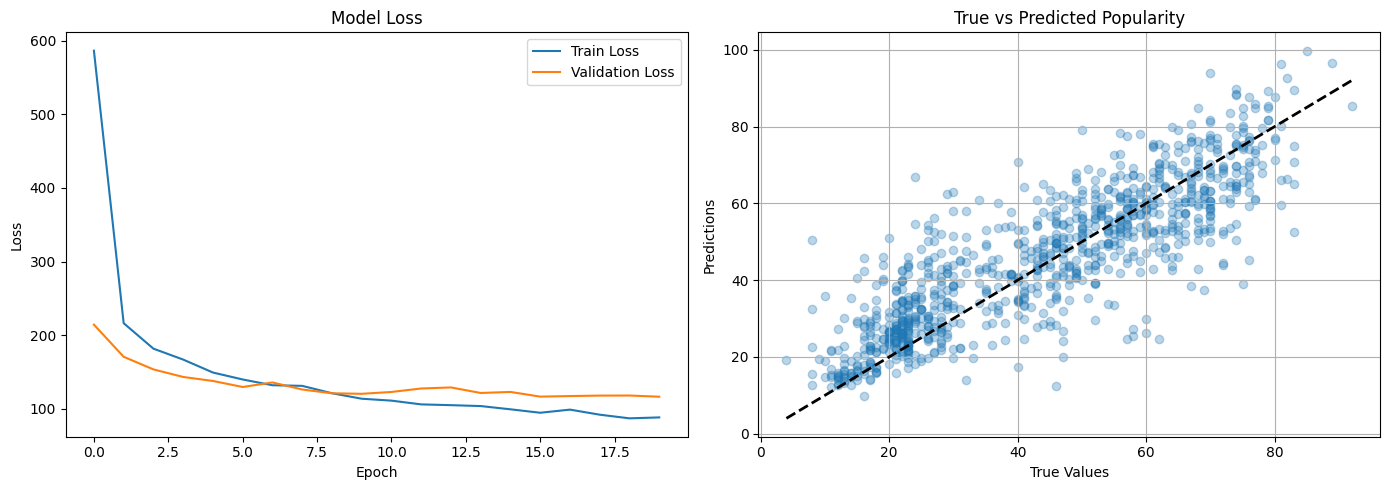

In [159]:
evaluate_model(model, X_train, y_train, X_test, y_test)

Linear regression can be a good choice for a dataset with 150 features and 5000 rows for several reasons:

### 1. **Simplicity and Interpretability**:
- **Simplicity**: Linear regression is simple to implement and understand.
- **Interpretability**: The coefficients in a linear regression model directly show the relationship between each feature and the target variable, which can be valuable for understanding the underlying data.

### 2. **Scalability**:
- **Computational Efficiency**: Linear regression is computationally efficient, making it suitable for datasets with a large number of features and rows. Training and prediction are relatively fast compared to more complex models like SVMs or decision trees.

### 3. **Assumptions and Data Suitability**:
- **Linear Relationships**: If the relationships between the features and the target variable are approximately linear, linear regression will perform well. Even if the relationships are not perfectly linear, it can still provide a good baseline model.
- **High-Dimensional Data**: Linear regression can handle high-dimensional data relatively well, especially if regularization techniques (like Ridge or Lasso regression) are used to prevent overfitting.

### 4. **Regularization**:
- **Ridge and Lasso Regression**: These extensions of linear regression can handle multicollinearity (when features are highly correlated) and reduce the risk of overfitting. Ridge regression (L2 regularization) adds a penalty for large coefficients, and Lasso regression (L1 regularization) can set some coefficients to zero, effectively performing feature selection.

### 5. **Baseline Performance**:
- **Baseline Model**: Linear regression provides a good baseline model. Its performance can be quickly evaluated and compared with more complex models. If linear regression performs well, it suggests that more complex models may not be necessary.


### Output Interpretation:
- **Mean Squared Error (MSE)**: The MSE values for each model (Linear, Ridge, and Lasso) help compare their performance. Lower MSE indicates better model performance.

### Advantages of Linear Regression:
- **Ease of Implementation**: Quick to set up and run.
- **Baseline Comparison**: Provides a reference point to compare with more complex models.
- **Resource Efficiency**: Less computationally intensive compared to more complex models like SVMs or ensemble methods.

### Summary:
Linear regression is a good choice because it is simple, interpretable, and computationally efficient. It can handle high-dimensional data well, especially when regularization is applied. By starting with linear regression, you can establish a baseline performance and determine if more complex models are necessary for your specific dataset.

In [160]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
print("Linear Regression Mean Squared Error:", mse_lin)

# Ridge Regression
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print("Ridge Regression Mean Squared Error:", mse_ridge)

# Lasso Regression
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train, y_train)
y_pred_lasso = lasso_reg.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print("Lasso Regression Mean Squared Error:", mse_lasso)


Linear Regression Mean Squared Error: 7.270522339926105e+20
Ridge Regression Mean Squared Error: 128.0307821200002
Lasso Regression Mean Squared Error: 184.99802465775542


In [161]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data["VIF"]>5)


c:\Users\Mr. Hajiheideri\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


0      False
1      False
2      False
3      False
4       True
       ...  
138     True
139     True
140     True
141     True
142     True
Name: VIF, Length: 143, dtype: bool


In [162]:
from scipy import stats

z_scores = stats.zscore(X)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
print(filtered_entries)


0       False
1       False
2       False
3       False
4       False
        ...  
4719    False
4720    False
4721    False
4722    False
4723    False
Length: 4724, dtype: bool


When selecting a machine learning algorithm for a regression problem, especially with a dataset of around 150 features and 5000 rows, it's important to consider the characteristics of each algorithm and how well they might handle the specific dataset. Let's briefly review each option:

### 1. Support Vector Machines (SVM)
- **Advantages**:
  - Effective in high-dimensional spaces (which is applicable given 150 features).
  - Can model non-linear relationships using the kernel trick.
- **Disadvantages**:
  - Computationally intensive and can be slow with large datasets.
  - Requires careful tuning of hyperparameters (e.g., the choice of kernel, regularization parameter).
  - Not easily interpretable.

### 2. Decision Trees
- **Advantages**:
  - Simple to understand and interpret.
  - Handles both numerical and categorical data.
  - Requires little data preprocessing (e.g., scaling is not necessary).
  - Can capture non-linear relationships.
- **Disadvantages**:
  - Prone to overfitting, especially with deep trees.
  - Can be sensitive to small variations in the data.

### 3. K-Nearest Neighbors (KNN)
- **Advantages**:
  - Simple and easy to implement.
  - No training phase (all computation is deferred to prediction time).
- **Disadvantages**:
  - Computationally expensive during prediction, especially with large datasets.
  - Performance can degrade with high-dimensional data due to the curse of dimensionality.
  - Requires careful selection of the number of neighbors (k) and distance metric.
  - Typically requires feature scaling.

### Recommendation
Given your dataset's size and the number of features, a decision tree might be the most suitable starting point for the following reasons:

1. **Interpretability**: Decision trees provide a clear and interpretable model structure.
2. **Handling of High-Dimensional Data**: While SVMs can handle high-dimensional data well, they may become computationally expensive with 5000 rows and require significant hyperparameter tuning. KNN, on the other hand, can suffer from the curse of dimensionality.
3. **Speed**: Decision trees are faster to train and predict compared to SVM and KNN in most cases.
4. **Flexibility**: Decision trees can handle both numerical and categorical features without requiring extensive preprocessing.

However, decision trees are prone to overfitting. To mitigate this, you can consider using ensemble methods like Random Forests or Gradient Boosting, which combine multiple decision trees to improve performance and robustness.

By starting with decision trees and considering ensemble methods, you can balance between model complexity, interpretability, and performance.

c:\Users\Mr. Hajiheideri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
4500 fits failed out of a total of 18000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2273 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Mr. Hajiheideri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Mr. Hajiheideri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Mr. Hajiheideri\AppData\Local\Programs\Pyt

Best Parameters: {'max_depth': None, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score (Negative MSE): -229.71841579590313


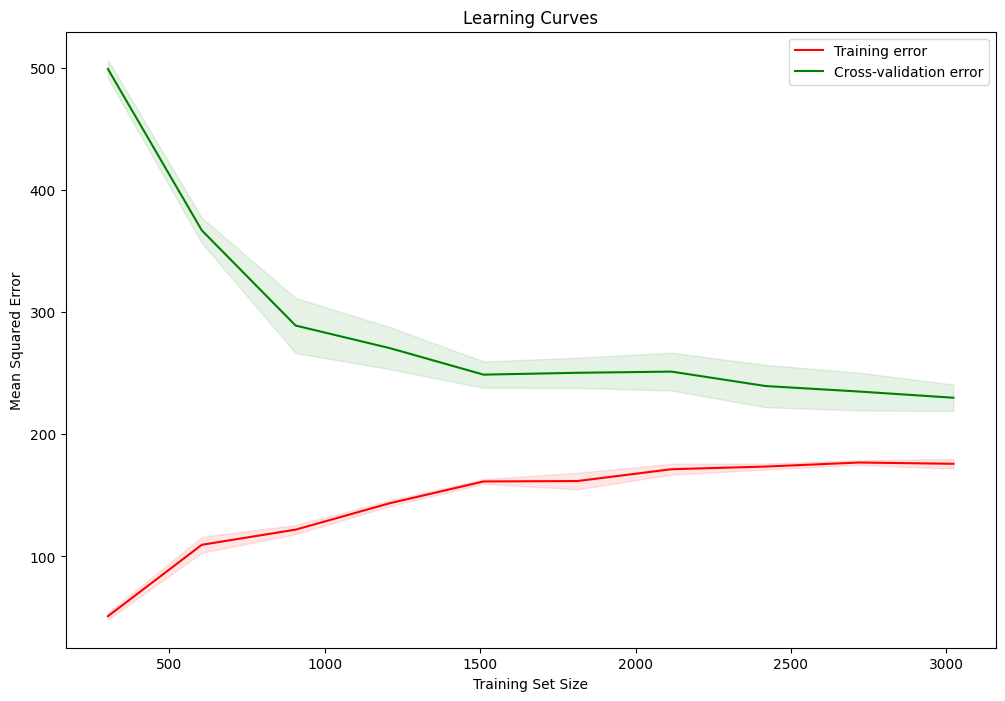

In [164]:
from sklearn.model_selection import  GridSearchCV, learning_curve
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50]
}

grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (Negative MSE):", best_score)

model = DecisionTreeRegressor(random_state=42, **best_params)

train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_scores_mean, label="Training error", color="r")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation error", color="g")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curves")
plt.legend(loc="best")
plt.show()


In [166]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(random_state=42, **best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# plt.figure(figsize=(12, 8))
# plot_tree(model, feature_names=X.columns, filled=True)
# plt.show()


Mean Squared Error: 217.5843587270484


## <a id="toc11_"></a>[Feature Analysis](#toc0_)

## <a id="toc12_"></a>[Overall Report and Discussions](#toc0_)